In [1]:
import datetime as dt
from keras.callbacks import EarlyStopping
from keras.layers import Dense  
from keras.layers import LSTM  
from keras.layers import Dropout 
from keras.models import Sequential, load_model 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import statistics

os.environ["CUDA_VISIBLE_DEVICES"]=str(0)



In [5]:
train_YN = 'Y'
initial_path = ''
plot_data = 'Y' 
train_record_number = 3516
test_record_number = 938
training_batch_size = 32
loss = 0
model_file = 'MODEL' + '-' + str(100) + '-' + str(0) + '.h5'

In [21]:
data_dataframe = pd.read_csv(str('DanishFinalData.csv'), index_col=False)
data_dataframe = data_dataframe.iloc[::-1].reset_index().replace('',np.nan).dropna(axis="rows", how="any")
data_dataframe['DateTime'] = pd.to_datetime(data_dataframe['DateCGM'])
data_dataframe['Date'] = data_dataframe['DateTime'].dt.date
data_dataframe['Time'] = data_dataframe['DateTime'].dt.time.apply(lambda t : t .strftime('%H:%M'))
hour_date=[]  

print(data_dataframe.head())
means_data = data_dataframe['Value CGM'].groupby([data_dataframe['Date'], data_dataframe['Time']]).mean()
print((means_data))

   index                     DateCGM  Value CGM                   DateBolus  \
0  35100  2017-07-24 18:59:42.000004      314.0  2017-07-25 12:08:54.000000   
1  35099  2017-07-24 18:59:44.000003      314.0  2017-07-25 12:08:54.000000   
2  35098  2017-07-24 19:00:01.000001      314.0  2017-07-25 12:08:54.000000   
3  35097  2017-07-24 19:02:03.000003      314.0  2017-07-25 12:08:54.000000   
4  35096  2017-07-24 19:30:37.000000      314.0  2017-07-25 12:08:54.000000   

   Value Bolus                   DateTime        Date   Time  
0          0.0 2017-07-24 18:59:42.000004  2017-07-24  18:59  
1          0.0 2017-07-24 18:59:44.000003  2017-07-24  18:59  
2          0.0 2017-07-24 19:00:01.000001  2017-07-24  19:00  
3          0.0 2017-07-24 19:02:03.000003  2017-07-24  19:02  
4          0.0 2017-07-24 19:30:37.000000  2017-07-24  19:30  
Date        Time 
2017-07-24  18:59    314.0
            19:00    314.0
            19:02    314.0
            19:30    314.0
2017-07-25  00:00    

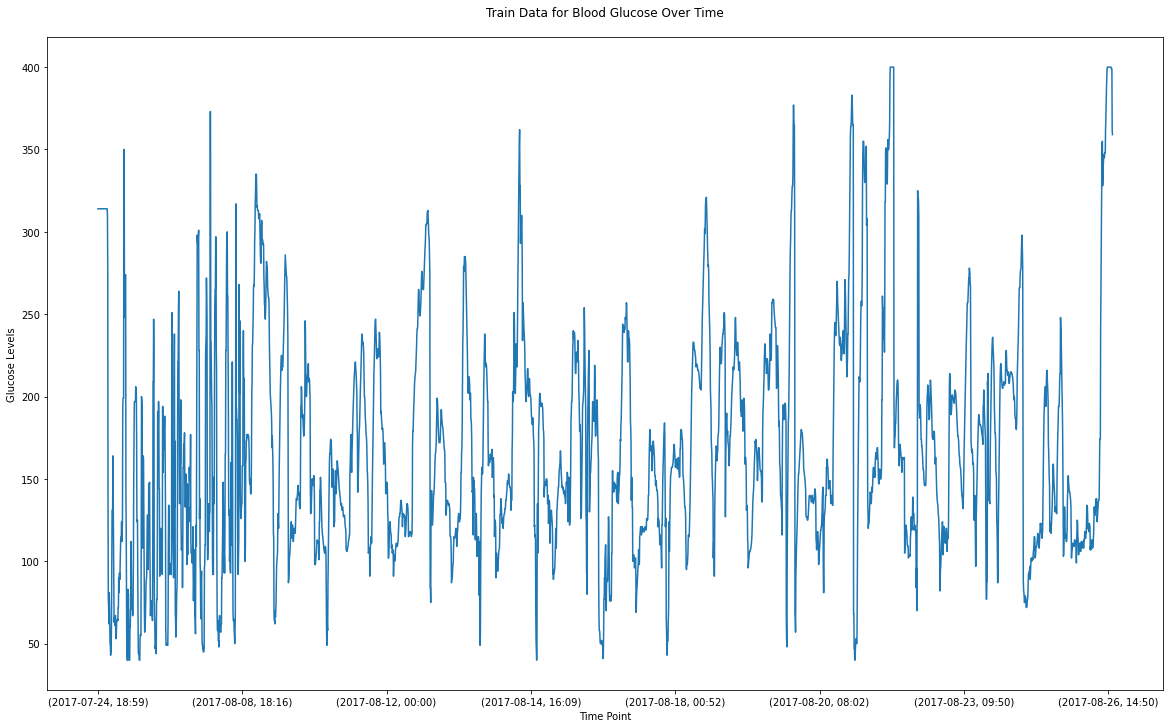

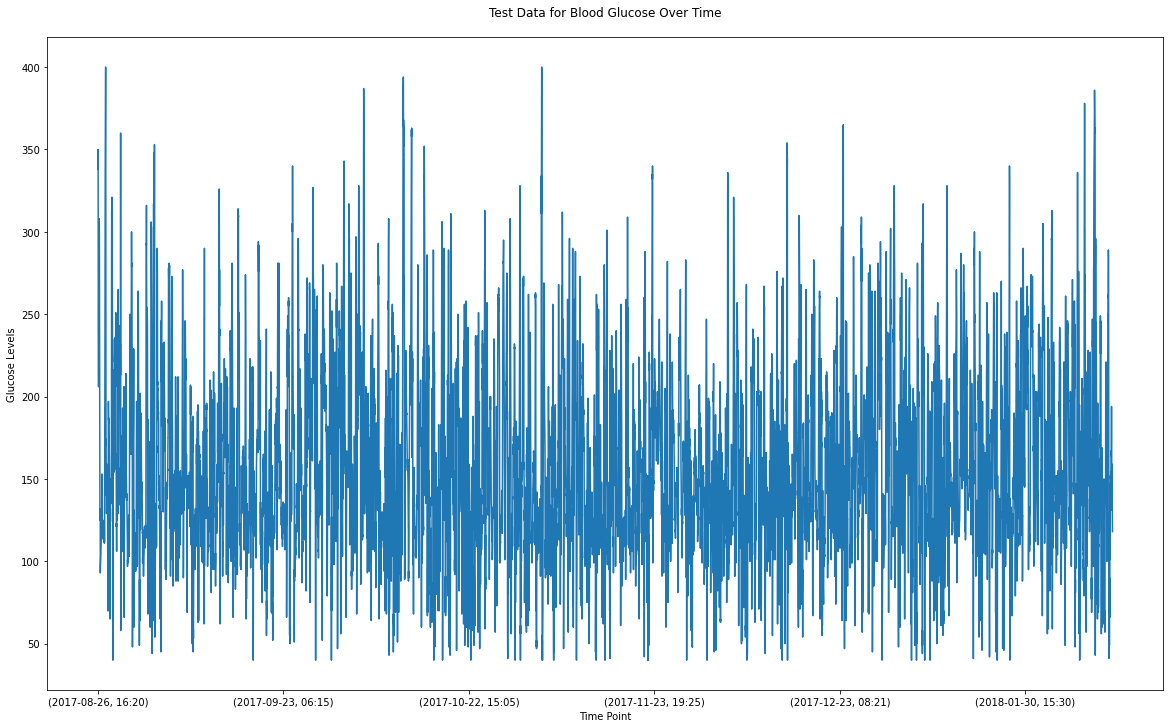

In [22]:
# Plot test and train data
if(plot_data == 'Y'):
  plt.figure(figsize=(20,12))
  means_data[:train_record_number].plot(kind='line', title='Train Data for Blood Glucose Over Time\n')
  plt.xlabel('Time Point')  
  plt.ylabel('Glucose Levels')
  plt.show()
  print('\n\n\n\n')
  plt.figure(figsize=(20,12))
  means_data[train_record_number:len(data_dataframe)].plot(kind='line', title='Test Data for Blood Glucose Over Time\n')
  plt.xlabel('Time Point')  
  plt.ylabel('Glucose Levels')
  plt.show()



In [23]:
train_glucose_dataframe = pd.DataFrame(columns=['Date_Hour', 'Glucose_Level'])
for i in range(0, 3516):
  temp_date = means_data.index[[i][0]]
  temp_date_hour = str(temp_date[0]) + ':' + str(temp_date[1])
  train_glucose_level = means_data[[i][0]]
  train_glucose_dataframe.loc[len(train_glucose_dataframe)] = [temp_date_hour, train_glucose_level]
test_glucose_df = pd.DataFrame(columns=['Date_Hour', 'Glucose_Level'])
for i in range(3516,4394):
  temp_date = means_data.index[[i][0]]
  temp_date_hour = str(temp_date[0]) + ':' + str(temp_date[1])
  test_glucose_level = means_data[[i][0]]
  test_glucose_df.loc[len(test_glucose_df)] = [temp_date_hour, test_glucose_level]

In [24]:
# LSTM
glucose_training_set = train_glucose_dataframe.iloc[:,1:2].values
glucose_training_set_scaled = MinMaxScaler(feature_range = (0,1)).fit_transform(glucose_training_set)

In [25]:

features_matrix = []  
labels = []  

for i in range(60, train_record_number):  
    features_matrix.append(glucose_training_set_scaled[i-60:i, 0])
    labels.append(glucose_training_set_scaled[i, 0])

In [26]:
features_matrix = np.array(features_matrix)
labels = np.array(labels)
features_matrix = np.reshape(features_matrix, (features_matrix.shape[0], features_matrix.shape[1], 1))

In [28]:
if train_YN == 'Y':
  model = Sequential()
  model.add(LSTM(units=50, return_sequences=True, input_shape=(features_matrix.shape[1], 1)))  
  model.add(Dropout(0.2))  
  model.add(LSTM(units=50, return_sequences=True))  
  model.add(Dropout(0.2))
  model.add(LSTM(units=50, return_sequences=True))  
  model.add(Dropout(0.2))
  model.add(LSTM(units=50))  
  model.add(Dropout(0.2)) 
  model.add(Dense(units = 1))  
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [29]:
if train_YN == 'Y':
  training_start_time = dt.datetime.now()
  from keras.callbacks import EarlyStopping
  es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)
  history = model.fit(features_matrix, labels, epochs = 100, batch_size = training_batch_size, callbacks = [es])  
  loss = model.evaluate(features_matrix, labels, verbose=0)
  model.save(str(initial_path + model_file))

  training_end_time = dt.datetime.now()
  training_total_time = str((training_end_time-training_start_time).total_seconds()) + ' seconds.'

Epoch 1/100
108/108 [==============================] - 19s 89ms/step - loss: 0.0305
Epoch 2/100
108/108 [==============================] - 10s 96ms/step - loss: 0.0184
Epoch 3/100
108/108 [==============================] - 10s 93ms/step - loss: 0.0143
Epoch 4/100
108/108 [==============================] - 10s 93ms/step - loss: 0.0114
Epoch 5/100
108/108 [==============================] - 9s 82ms/step - loss: 0.0093
Epoch 6/100
108/108 [==============================] - 7s 66ms/step - loss: 0.0096
Epoch 7/100
108/108 [==============================] - 7s 64ms/step - loss: 0.0080
Epoch 8/100
108/108 [==============================] - 7s 67ms/step - loss: 0.0065
Epoch 9/100
108/108 [==============================] - 8s 76ms/step - loss: 0.0062
Epoch 10/100
108/108 [==============================] - 8s 74ms/step - loss: 0.0060
Epoch 11/100
108/108 [==============================] - 7s 67ms/step - loss: 0.0054
Epoch 12/100
108/108 [==============================] - 8s 70ms/step - loss: 0.00

In [30]:
glucose_total = pd.DataFrame(columns=['Glucose_Level'])
glucose_total = pd.concat((train_glucose_dataframe['Glucose_Level'], test_glucose_df['Glucose_Level']), axis=0) 

In [34]:
test_inputs = glucose_total[len(train_glucose_dataframe) - 60:].values.reshape(-1,1)  
scaler = MinMaxScaler(feature_range = (0,1))
test_inputs = scaler.fit_transform(test_inputs)

In [36]:
test_features = []  
for i in range(60, test_record_number):  
    test_features.append(test_inputs[i-60:i, 0])
    
test_features = np.array(test_features)  
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))      

In [37]:
inf_start_time = dt.datetime.now()
predictions = load_model(str(initial_path + model_file)).predict(test_features)  
predictions = scaler.inverse_transform(predictions)
actual_predicted_difference_list = []
for i in range(0,len(predictions)):
    print('\nActual value for ' + str(test_glucose_df.loc[i,'Date_Hour']) + ' = ' 
          + str(test_glucose_df.loc[i,'Glucose_Level']))
    print('Predicted value = {0}'.format(predictions[i,0]))
    actual_predicted_difference_list.append((predictions[i,0] - test_glucose_df.loc[i,'Glucose_Level']) ** 2)
mean_square = statistics.mean(actual_predicted_difference_list)
print('Mean square error = ' + str(mean_square))

inf_end_time = dt.datetime.now()
inf_total_time = str((inf_end_time-inf_start_time).total_seconds()) + ' seconds.'
print('\n\nTotal inference time ' + inf_total_time)


28/28 [==============================] - 12s 48ms/step

Actual value for 2017-08-26:16:20 = 338.0
Predicted value = 346.134521484375

Actual value for 2017-08-26:16:25 = 345.0
Predicted value = 305.01910400390625

Actual value for 2017-08-26:16:30 = 350.0
Predicted value = 333.78411865234375

Actual value for 2017-08-26:16:35 = 346.0
Predicted value = 327.6381530761719

Actual value for 2017-08-26:16:36 = 346.0
Predicted value = 335.2611083984375

Actual value for 2017-08-26:16:37 = 346.0
Predicted value = 333.9910583496094

Actual value for 2017-08-26:16:41 = 314.0
Predicted value = 336.1550598144531

Actual value for 2017-08-26:16:45 = 300.0
Predicted value = 291.7799987792969

Actual value for 2017-08-26:16:50 = 295.0
Predicted value = 288.107177734375

Actual value for 2017-08-26:17:20 = 241.0
Predicted value = 280.2873840332031

Actual value for 2017-08-26:17:25 = 244.0
Predicted value = 209.71463012695312

Actual value for 2017-08-26:17:30 = 240.0
Predicted value = 234.0450286865

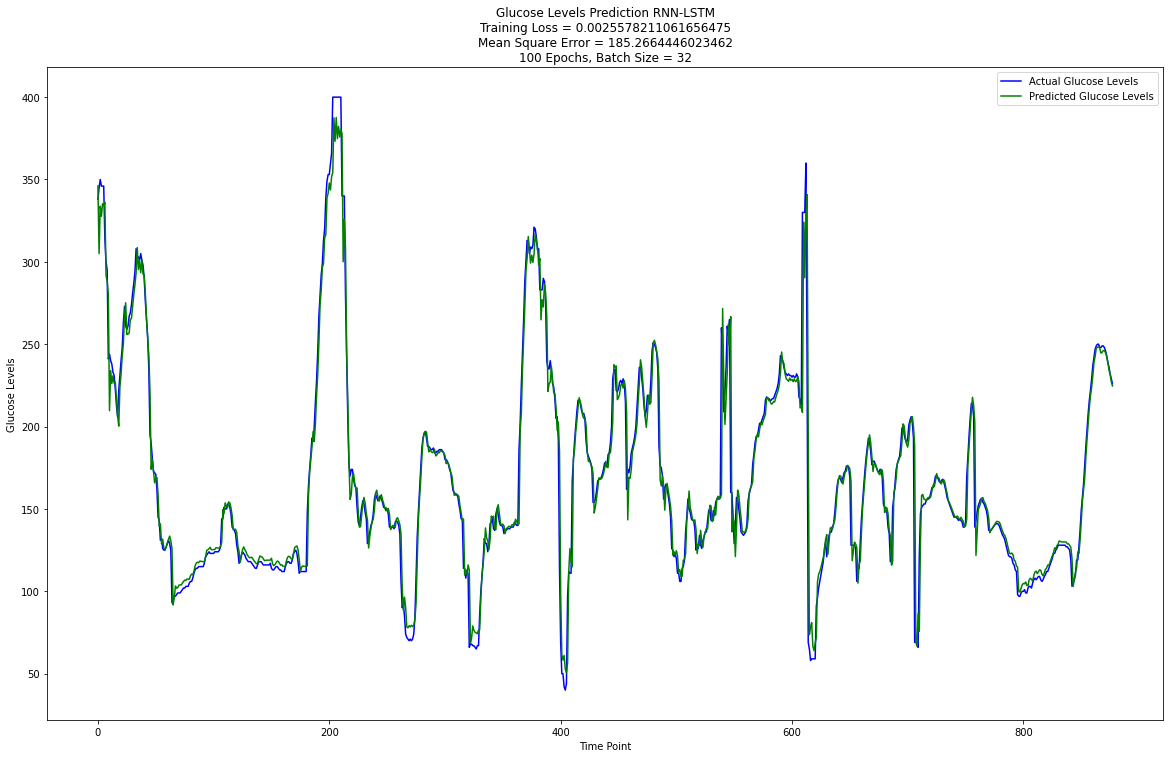

In [40]:
actual = test_glucose_df['Glucose_Level'].values[0:len(test_glucose_df)]
plot_data = 'Y' # Values are Y or N
plt.figure(figsize=(20,12))  
plt.plot(actual, color='blue', label='Actual Glucose Levels')  
plt.plot(predictions , color='green', label='Predicted Glucose Levels')  
plt.title('Glucose Levels Prediction RNN-LSTM' + '\nTraining Loss = ' +
         str(loss) + '\nMean Square Error = ' + str(mean_square) + '\n' + str(100) + ' Epochs, ' +
         'Batch Size = ' + str(training_batch_size))  
plt.xlabel('Time Point')  
plt.ylabel('Glucose Levels')  
plt.legend()  
plt.show() 

In [39]:
print('Training Loss = ' + str(loss))
print('Mean Square Error = ' + str(mean_square))
print('\n\nTotal inference time ' + inf_total_time)

Training Loss = 0.0025578211061656475
Mean Square Error = 185.2664446023462


Total inference time 19.505747 seconds.
